In [3]:
!pip install -q ultralytics imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00:00:0100:01


In [4]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [5]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

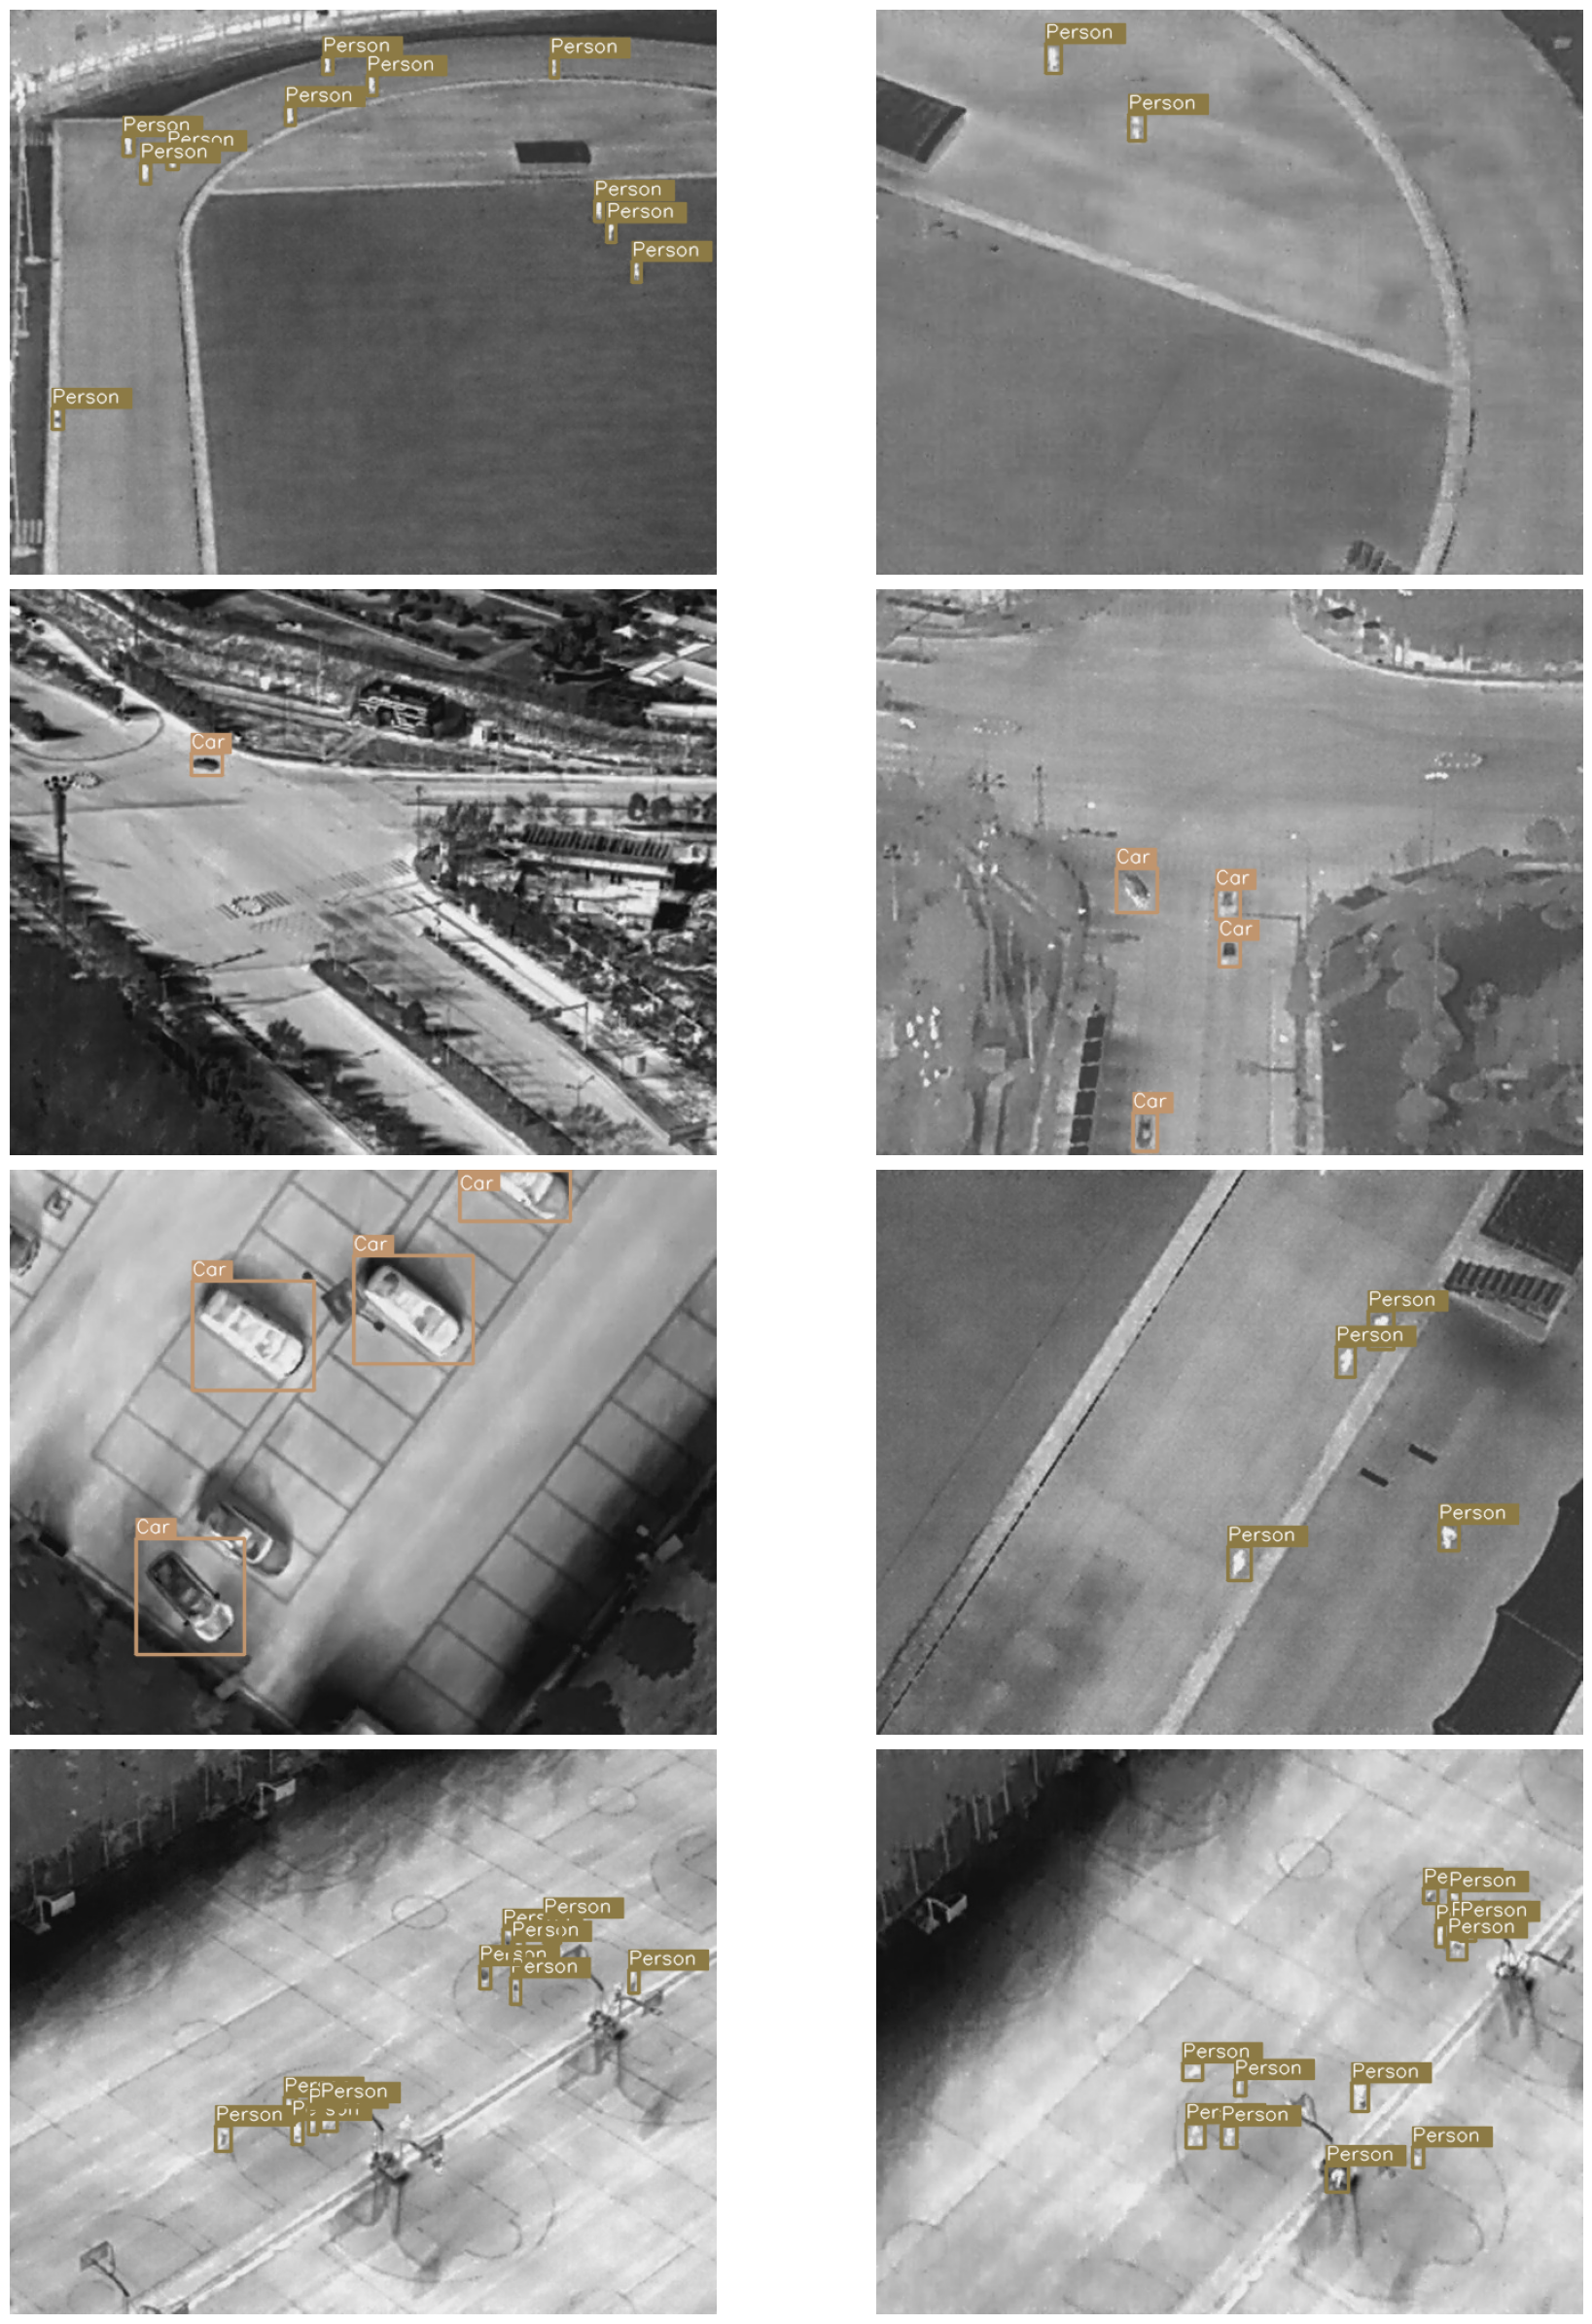

In [9]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [13]:
import yaml
import os

# =================================================================
# BƯỚC 1: ĐẢM BẢO FILE YAML VÀ DATASET.YAML ĐƯỢC TẠO
# =================================================================

# Tạo data.yaml
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}
with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)

# =================================================================
# BƯỚC 2: ĐỊNH NGHĨA MODEL_DICT (MobileNetV3-Large - Đã sửa lỗi)
# =================================================================
model_dict = {
    "nc": 5,

    # Layer 0: Load MobileNetV3-Large (YOLO cắt ở Index 15)
    "backbone": [
        [-1, 1, "TorchVision", [960, "mobilenet_v3_large", "DEFAULT", True, 2, True]], # backbone index 0
        [-1, 1, "nn.Identity", []], # index 1
        [-1, 1, "nn.Identity", []], # index 2

        # ------ TÁCH RIÊNG: Lấy (Tap) cả 3 feature map trước
        [0, 1, "Index", [40, 6]],  # index 3 (Tap P3 - 40 kênh)
        [0, 1, "Index", [112, 12]], # index 4 (Tap P4 - 112 kênh)
        [0, 1, "Index", [160, 15]], # index 5 (SỬA LỖI: Tap P5 - 160 kênh)

        # ------ TÁCH RIÊNG: Chiếu (Project) và Ghim (Pin) P3
        [3, 1, "Conv", [256, 1, 1]], # index 6 (Project 40 -> 256)
        [-1, 1, "nn.Identity", []], # index 7 (Pin P3)

        # ------ TÁCH RIÊNG: Chiếu (Project) và Ghim (Pin) P4
        [4, 1, "Conv", [512, 1, 1]], # index 8 (Project 112 -> 512)
        [-1, 1, "nn.Identity", []], # index 9 (Pin P4)

        # ---------------- TÁCH RIÊNG: Chiếu (Project) và Ghim (Pin) P5
        [5, 1, "Conv", [1024, 1, 1]], # index 10 (SỬA LỖI: Project 160 -> 1024)
        [-1, 1, "SPPF", [1024, 5]] # index 11 (Pin P5)
    ],
    
    # Head (Các chỉ số Pin đã đúng: 7, 9, 11)
    "head": [
        [-1, 1, "nn.Upsample", [None, 2, "nearest"]], # index 12 (from 11)
        [[-1, 9], 1, "Concat", [1]], # Concat P5_upsampled + P4 (Pin index 9)
        [-1, 3, "C2f", [512, True]], # index 14

        [-1, 1, "nn.Upsample", [None, 2, "nearest"]], # index 15 (from 14)
        [[-1, 7], 1, "Concat", [1]], # Concat P4_upsampled + P3 (Pin index 7)
        [-1, 3, "C2f", [256, True]], # index 17

        [-1, 1, "Conv", [256, 3, 2]], # index 18 (from 17)
        [[-1, 14], 1, "Concat", [1]], # Concat P3_downsampled + P4_C2f (index 14)
        [-1, 3, "C2f", [512, True]], # index 20

        [-1, 1, "Conv", [512, 3, 2]], # index 21 (from 20)
        [[-1, 11], 1, "Concat", [1]], # Concat P4_downsampled + P5 (Pin index 11)
        [-1, 3, "C2f", [1024, True]], # index 23

        [[17, 20, 23], 1, "Detect", ["nc"]] # Detect from 17, 20, 23
    ]
}

# =================================================================
# BƯỚC 3: XÓA FILE CŨ (NẾU CÓ) VÀ GHI FILE MỚI
# =================================================================
yaml_path = "/kaggle/working/yolov8-custom.yaml"
if os.path.exists(yaml_path):
    os.remove(yaml_path)
    print(f"Đã xóa file .yaml cũ: {yaml_path}")

with open(yaml_path, "w") as f:
    yaml.dump(model_dict, f, sort_keys=False)

print(f"Đã tạo file .yaml mới (MobileNetV3 - Đã sửa lỗi) tại: {yaml_path}")

Đã xóa file .yaml cũ: /kaggle/working/yolov8-custom.yaml
Đã tạo file .yaml mới (MobileNetV3 - Đã sửa lỗi) tại: /kaggle/working/yolov8-custom.yaml


In [14]:
from ultralytics import YOLO

yolo_efficientnet_model = YOLO('/kaggle/working/yolov8-custom.yaml')

In [15]:
yolo_efficientnet_train = yolo_efficientnet_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 16)

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/yolov8-custom.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

In [16]:
!ls -l /kaggle/working/runs/detect/

total 4
drwxr-xr-x 3 root root 4096 Nov 15 08:32 train


In [17]:
best_efficientnet_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [18]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [19]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/val_batch0_pred.jpg (deflated 6%)
  adding: runs/detect/train/val_batch1_pred.jpg (deflated 7%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 22%)
  adding: runs/detect/train/train_batch5042.jpg (deflated 10%)
  adding: runs/detect/train/train_batch0.jpg (deflated 4%)
  adding: runs/detect/train/val_batch2_pred.jpg (deflated 6%)
  adding: runs/detect/train/train_batch5040.jpg (deflated 11%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/results.png (deflated 8%)
  adding: runs/detect/train/train_batch1.jpg (deflated 4%)
  adding: runs/detect/train/val_batch1_labels.jpg (deflated 8%)
  adding: runs/detect/train/train_batch5041.jpg (deflated 13%)
  adding: runs/detect/train/BoxR_curve.png (deflated 9%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: runs/detect/train/confus

In [20]:
!ls -lh /kaggle/working/


total 169M
-rw-r--r-- 1 root root  325 Nov 15 07:14 dataset.yaml
drwxr-xr-x 3 root root 4.0K Nov 15 07:14 runs
-rw-r--r-- 1 root root 163M Nov 15 08:33 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 15 07:14 yolo11n.pt
-rw-r--r-- 1 root root 1.2K Nov 15 07:14 yolov8-custom.yaml


# Inference on Test Images


In [21]:
results = best_efficientnet_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 1 Person, 10 Cars, 58.2ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 7 Cars, 2 OtherVehicles, 20.4ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 12 Cars, 1 OtherVehicle, 19.8ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 3 Cars, 19.8ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 2 Persons, 20.0ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 2 Persons, 19.8ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x6

In [22]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




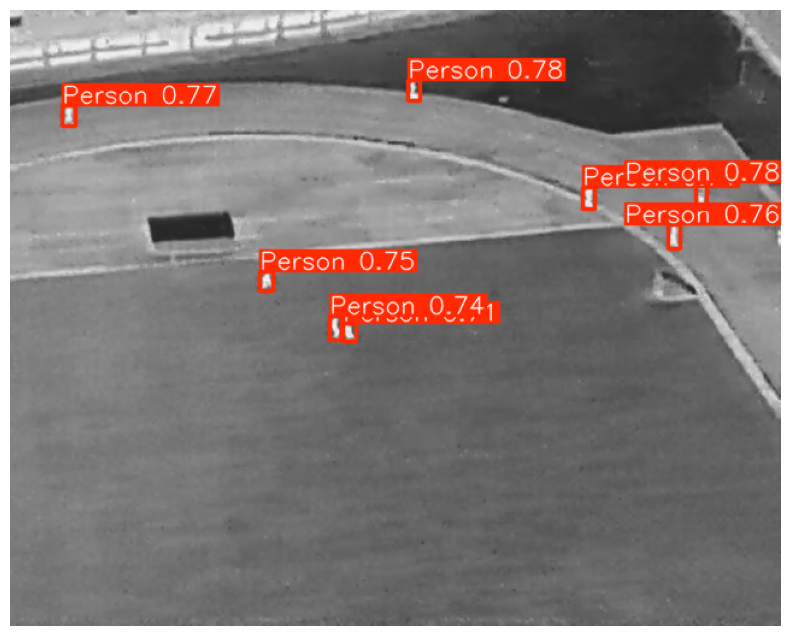

In [23]:
show_random_result(results)

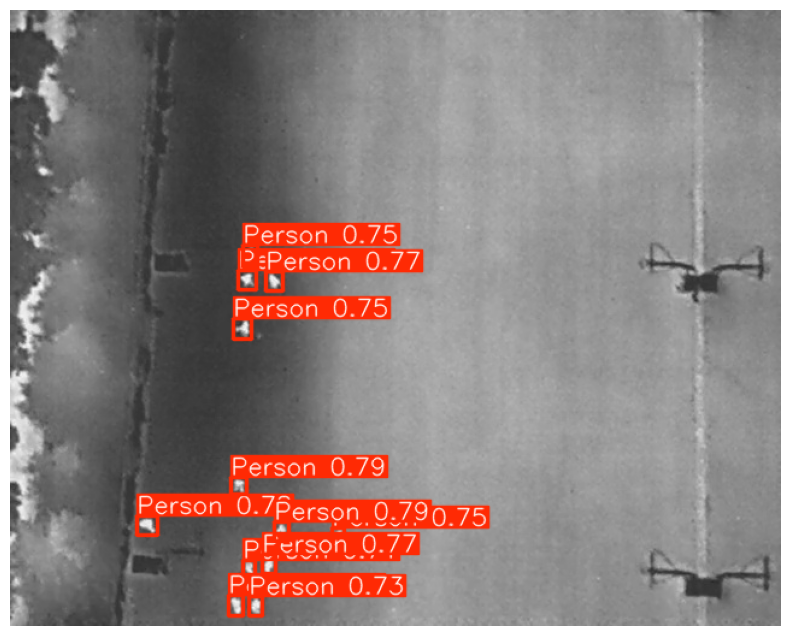

In [24]:
show_random_result(results)

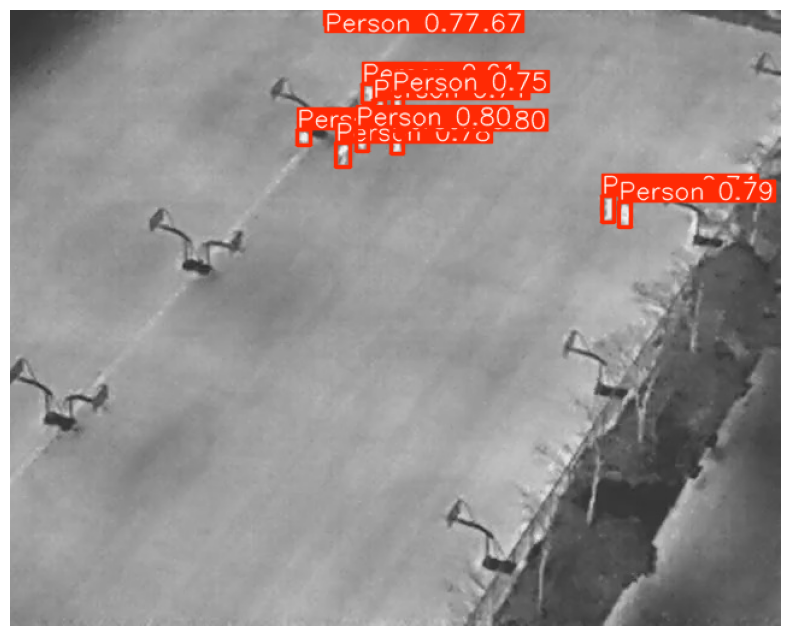

In [25]:

show_random_result(results)

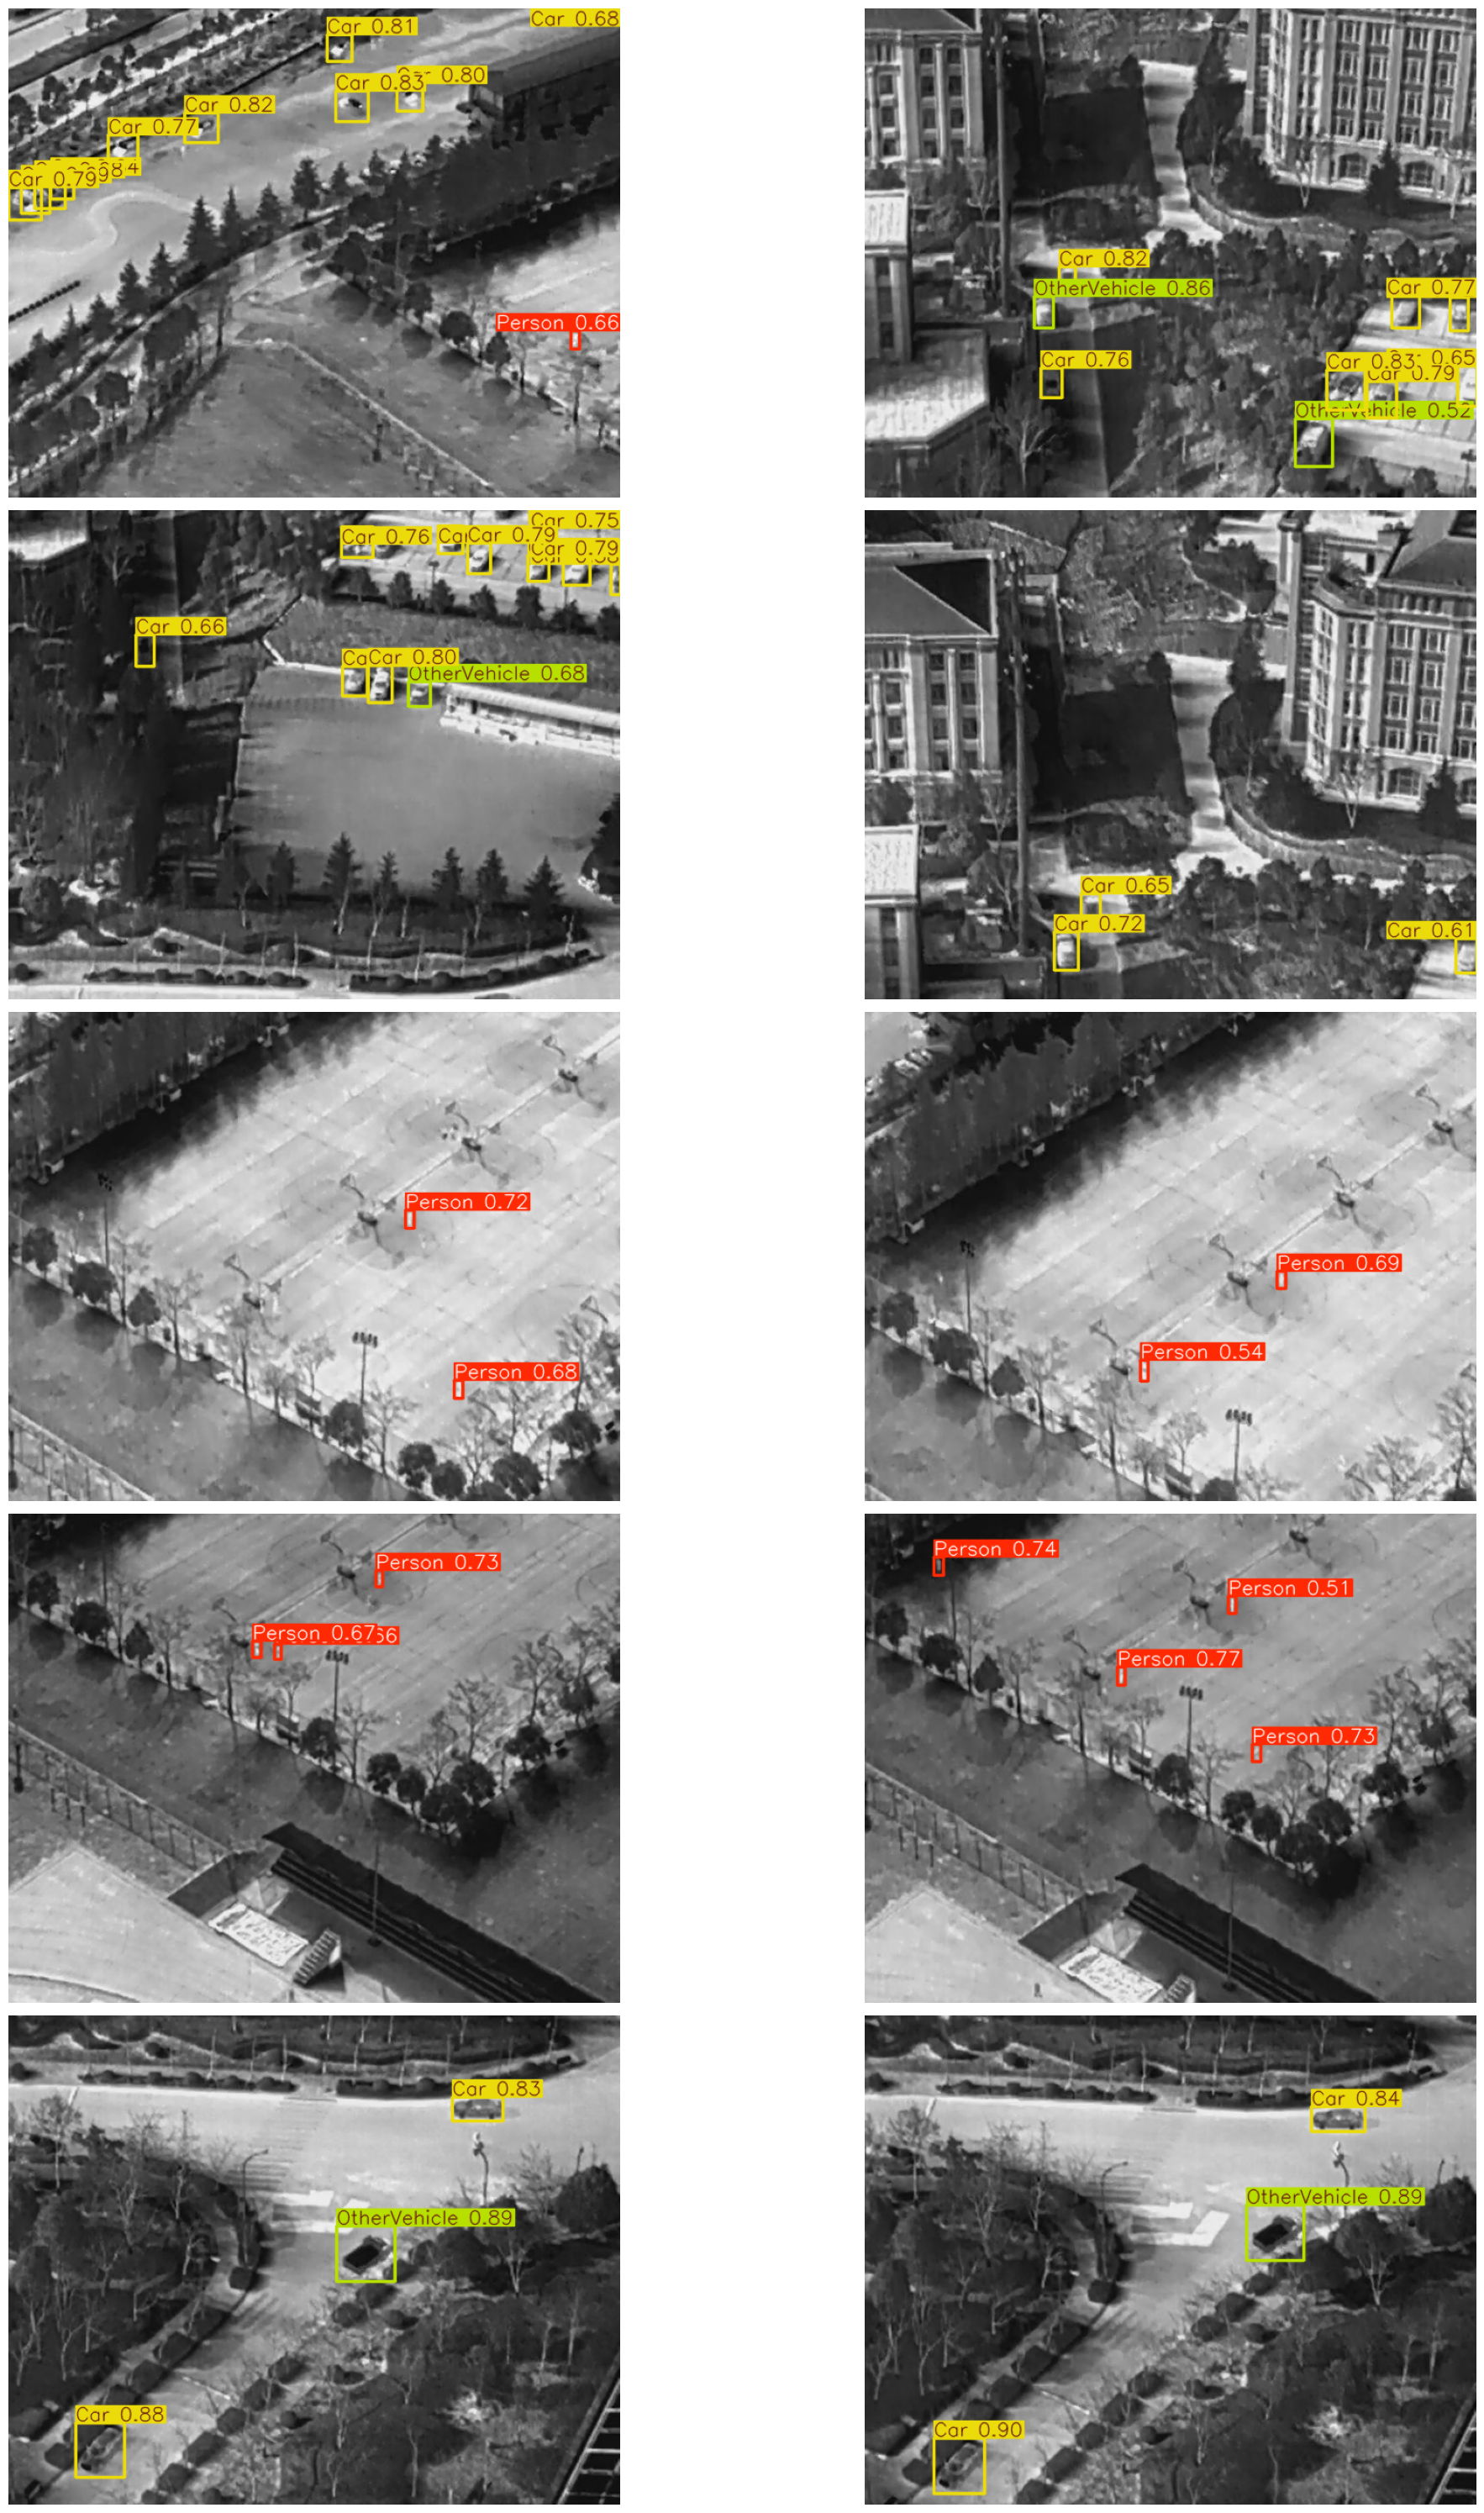

In [26]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [27]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [28]:
!ls runs/detect

predict  train


In [29]:
success = best_efficientnet_model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8-custom summary: 236 layers, 45,012,367 parameters, 0 gradients, 99.7 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (86.3 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 528ms
 Downloaded sympy
 Downloaded onnxruntime-gpu
Prepared 6 packages in 3.45s
Uninstalled 2 packages in 182ms
Installed 6 packages in 46ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74
 - protobuf==3.20.3
 + protobuf==6.33.1
 - sympy==1.13.1
 + sympy==1.14.0

requirements: AutoUpdate success ✅ 4.7s


'/kaggle/working/runs/detect/train/weights/best.onnx'